Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

## Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 1. Data Reading/Data Understanding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/CNN_Data/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/CNN_Data/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## 2. Dataset creation

Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3. Dataset visualisation

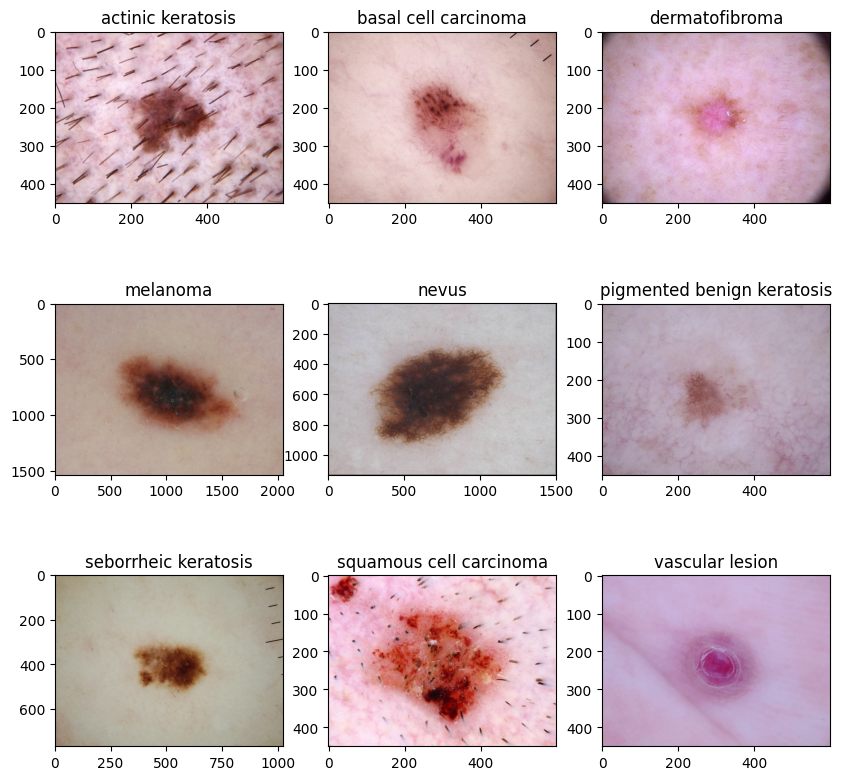

In [ ]:
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Model Building & training

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [ ]:
from tensorflow.keras.optimizers import RMSprop

Model Compilation

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

Train the Model (20 epochs)

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 302s 1s/step - loss: 2.0614 - accuracy: 0.1914 - val_loss: 2.0299 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 90ms/step - loss: 2.0039 - accuracy: 0.2294 - val_loss: 2.0062 - val_accuracy: 0.2327
Epoch 3/20
56/56 [==============================] - 5s 89ms/step - loss: 1.8096 - accuracy: 0.3276 - val_loss: 1.7211 - val_accuracy: 0.3468
Epoch 4/20
56/56 [==============================] - 5s 91ms/step - loss: 1.5833 - accuracy: 0.4342 - val_loss: 1.5122 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 5s 89ms/step - loss: 1.5216 - accuracy: 0.4743 - val_loss: 1.5070 - val_accuracy: 0.4541
Epoch 6/20
56/56 [==============================] - 5s 89ms/step - loss: 1.4475 - accuracy: 0.4794 - val_loss: 1.4752 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 5s 91ms/step - loss: 1.4670 - accuracy: 0.4682 - val_loss: 1.5502 - val_accuracy: 0.4698
Epoch 8/20
56/56 [======

Visualizing training results

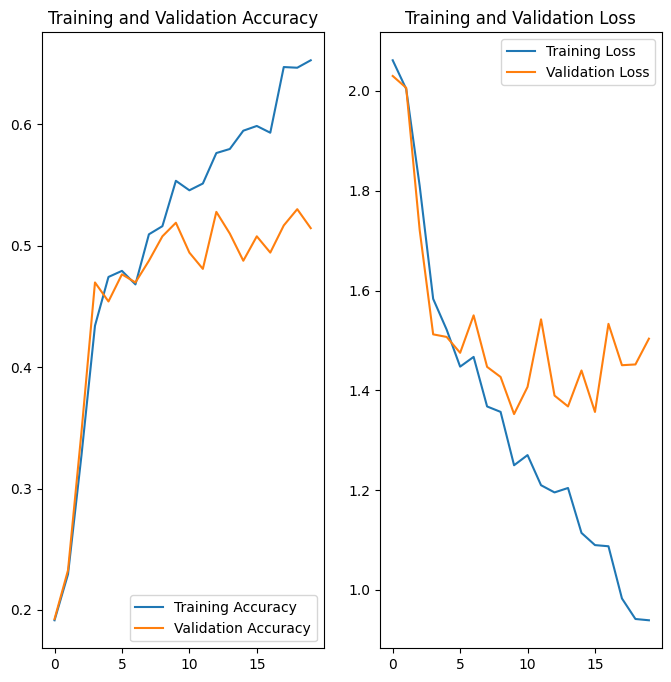

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Check if model whether overfitting or underfitting


Findings: There is a huge difference of 14% between Validation and Training accuracy so model is overfitting. We will use data augmentation and dropouts to solve this

## 5. Data Augmentation

In [ ]:
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

Visualize augmentation strategy for one instance of training image

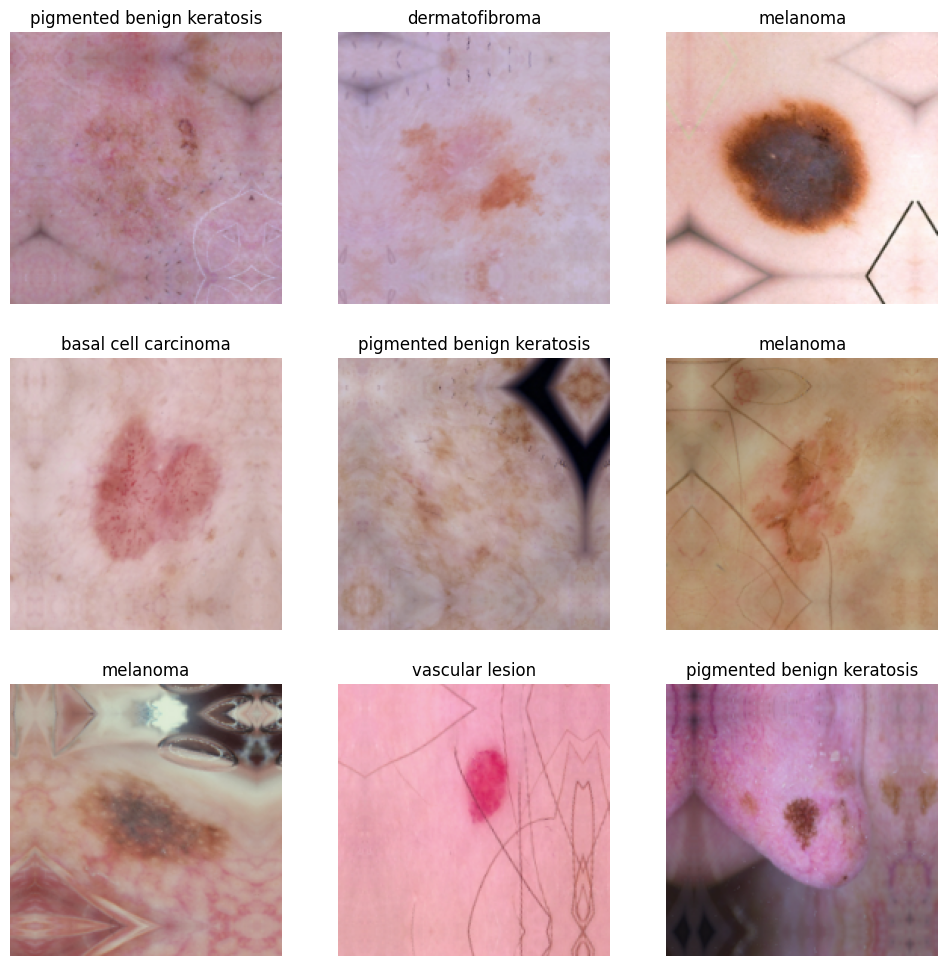

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 6. Model Building & training

Create the model, compile and train the model

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        25632     
                                                      

Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model (20 epochs)

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 97ms/step - loss: 2.0373 - accuracy: 0.2132 - val_loss: 2.0787 - val_accuracy: 0.1588
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 1.9009 - accuracy: 0.2807 - val_loss: 1.8547 - val_accuracy: 0.2729
Epoch 3/20
56/56 [==============================] - 5s 93ms/step - loss: 1.8988 - accuracy: 0.3008 - val_loss: 1.7703 - val_accuracy: 0.3423
Epoch 4/20
56/56 [==============================] - 5s 90ms/step - loss: 1.7934 - accuracy: 0.3504 - val_loss: 1.6860 - val_accuracy: 0.3848
Epoch 5/20
56/56 [==============================] - 5s 90ms/step - loss: 1.6762 - accuracy: 0.3839 - val_loss: 1.6388 - val_accuracy: 0.4273
Epoch 6/20
56/56 [==============================] - 5s 93ms/step - loss: 1.6396 - accuracy: 0.4141 - val_loss: 1.6250 - val_accuracy: 0.4385
Epoch 7/20
56/56 [==============================] - 5s 91ms/step - loss: 1.6552 - accuracy: 0.3945 - val_loss: 1.5632 - val_accuracy: 0.4855
Epoch 8/20
56

Visualizing the results

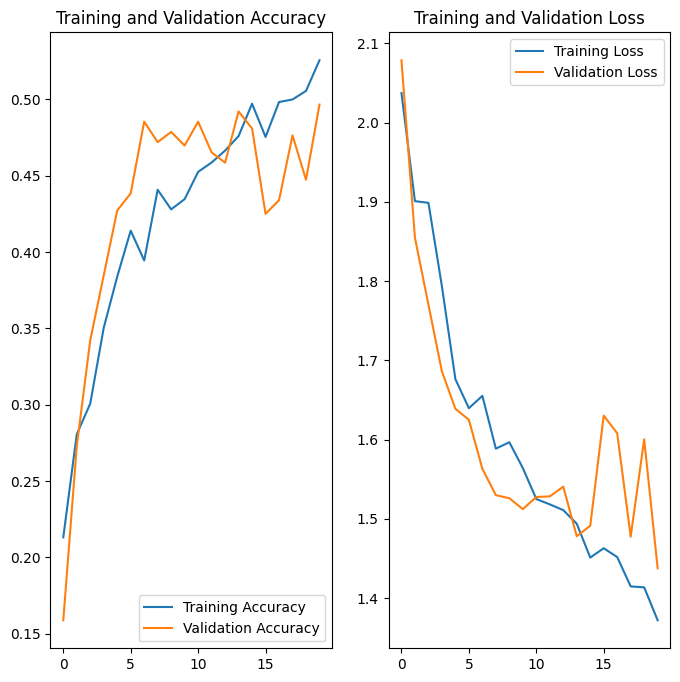

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings: After tuning the model, validation and training accuracy are similar i.e. difference of 3%

## 7. Class distribution

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

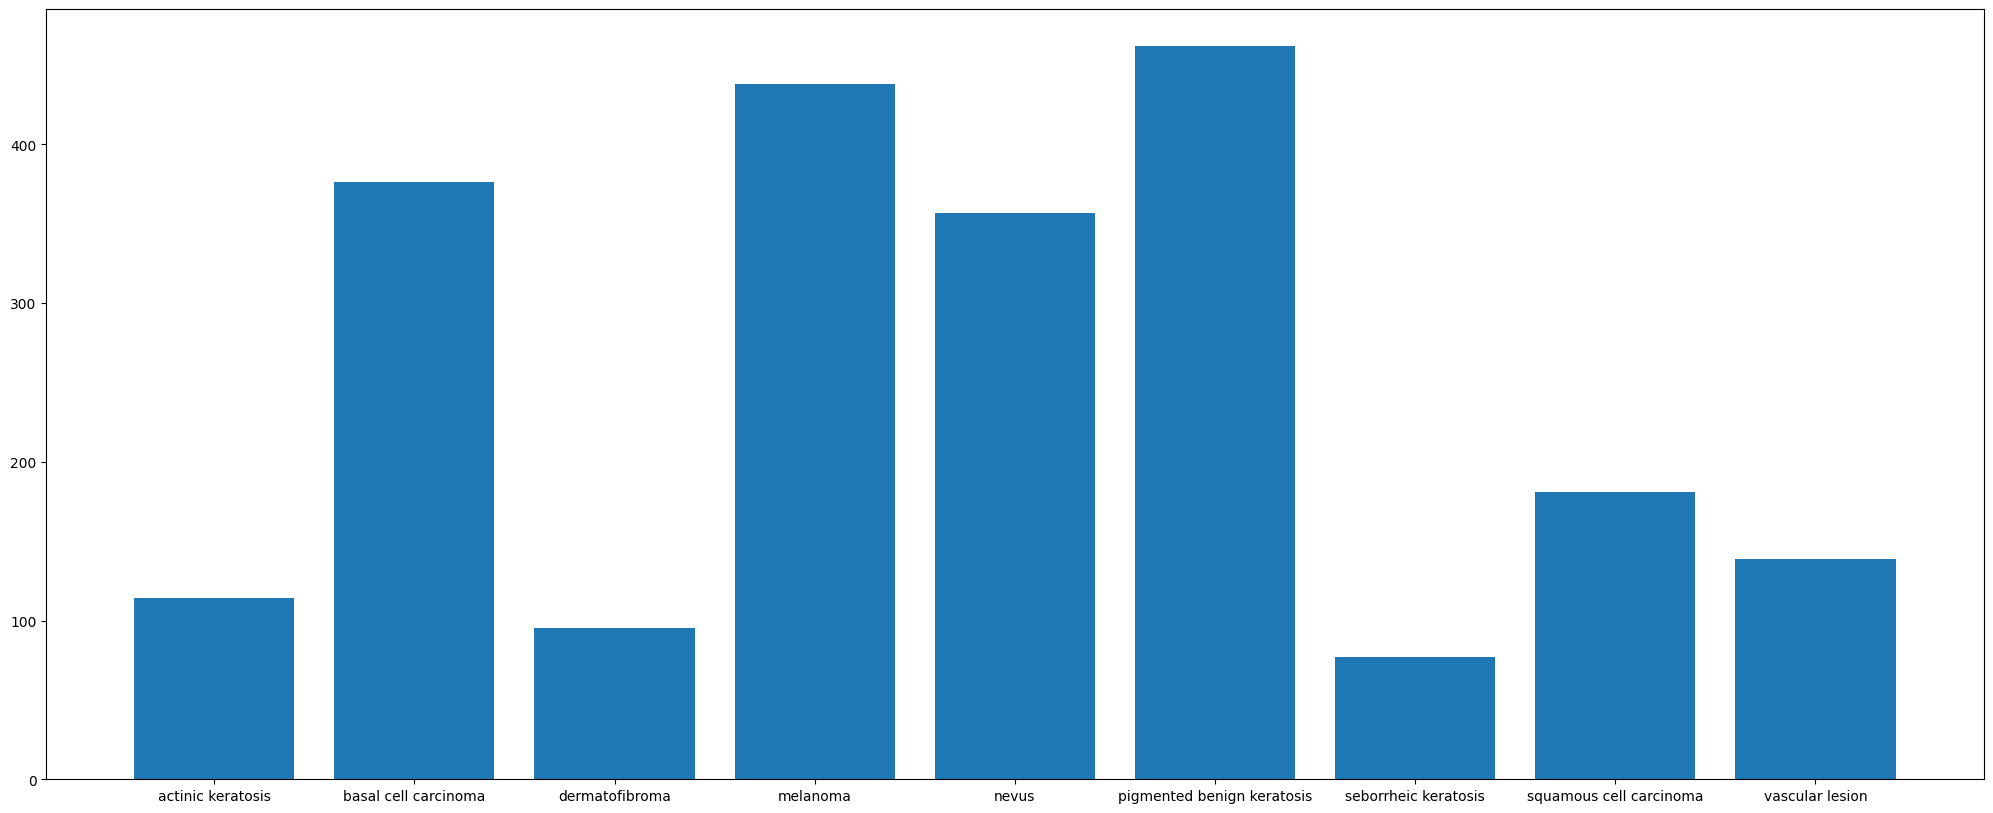

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

Findings

Which class has the least number of samples?
Answer: Seborrheic keratosis and Dermatofibroma

Which classes dominate the data in terms proportionate number of samples?
Answer: Pigmented benign keratosis

**Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

## 8. Handling class imbalances

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [ ]:
path_to_training_dataset="/content/drive/MyDrive/CNN_Data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2BE054B040>: 100%|██████████| 500/500 [00:28<00:00, 17.85 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2BE05A3FA0>: 100%|██████████| 500/500 [00:21<00:00, 23.48 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2BE40DB0D0>: 100%|██████████| 500/500 [00:21<00:00, 23.63 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C2BE4054E20>: 100%|██████████| 500/500 [01:29<00:00,  5.57 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2314x2067 at 0x7C2BE0548A00>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2BFC0B3CA0>: 100%|██████████| 500/500 [00:18<00:00, 26.78 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C2BFC09ADD0>: 100%|██████████| 500/500 [00:42<00:00, 11.68 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2BFF71FA30>: 100%|██████████| 500/500 [00:19<00:00, 26.04 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C2BFF740520>: 100%|██████████| 500/500 [00:20<00:00, 23.94 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/CNN_Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025583.jpg_c7daf17b-2820-45f5-a604-770cd1f38c44.jpg',
 '/content/drive/MyDrive/CNN_Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027083.jpg_3ca12859-c167-4c23-b0a0-65085e299808.jpg',
 '/content/drive/MyDrive/CNN_Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026290.jpg_ec2a8b1a-07fa-4f1d-97e7-c7e6b11f870b.jpg',
 '/content/drive/MyDrive/CNN_Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028623.jpg_62f96d11-08f6-49b5-815d-f5433762f3a1.jpg',
 '/content/drive/MyDrive/CNN_Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027275.jpg_1e188ece-4a39-4f36-9f79-0b1946215c5a.jpg',
 '/content/drive/MyDrive/CNN_Data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025032.jpg_3d888d42-6373-47c2-a624

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    500
dermatofibroma                500
actinic keratosis             500
nevus                         500
vascular lesion               500
melanoma                      500
squamous cell carcinoma       500
seborrheic keratosis          500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## 9. Model Building & training

Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [ ]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create your model (make sure to include normalization)

In [ ]:
from tensorflow.keras.layers import BatchNormalization
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization (Batch  (None, 89, 89, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_14 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 43, 43, 64)       

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

Train your model (50 epochs)

In [ ]:
epochs = 50
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 1.6259 - accuracy: 0.4414
Epoch 1: val_accuracy improved from -inf to 0.11507, saving model to model.h5
169/169 [==============================] - 17s 76ms/step - loss: 1.6259 - accuracy: 0.4414 - val_loss: 2.8730 - val_accuracy: 0.1151
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 1.1424 - accuracy: 0.5935
Epoch 2: val_accuracy improved from 0.11507 to 0.13363, saving model to model.h5
169/169 [==============================] - 11s 67ms/step - loss: 1.1424 - accuracy: 0.5935 - val_loss: 3.2003 - val_accuracy: 0.1336
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 0.8111 - accuracy: 0.7088
Epoch 3: val_accuracy improved from 0.13363 to 0.45360, saving model to model.h5
169/169 [==============================] - 12s 69ms/step - loss: 0.8111 - accuracy: 0.7088 - val_loss: 1.6625 - val_accuracy: 0.4536
Epoch 4/50
169/169 [==============================] - ETA: 0s - loss: 0.6

Visualize the model results

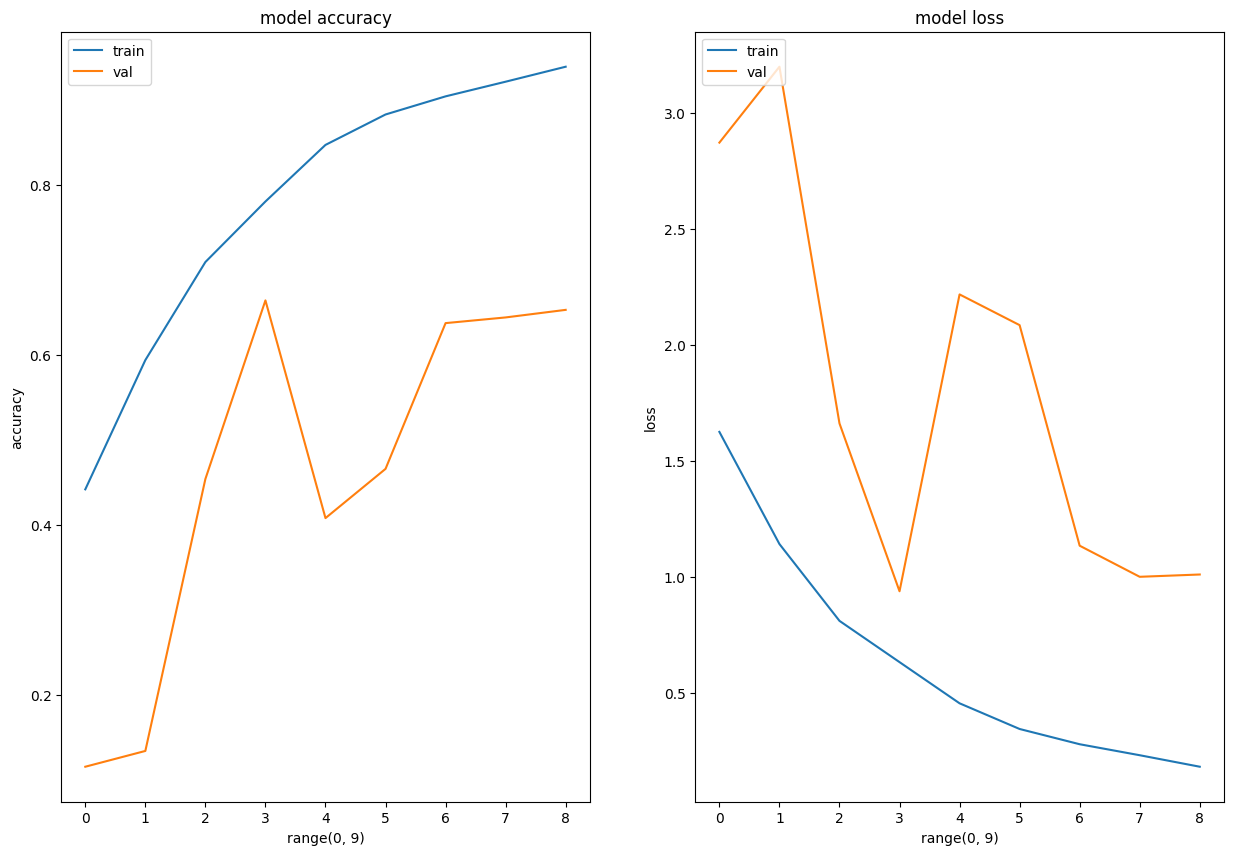

In [ ]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Findings: We see that training accuracy is over 90% while validtaion accuracy is 65% which is good enough however model is overfitting. So class rebalance did not help much.